In [1]:
#This project was largely a learning opportunity to understand compromises between Domain-based inferences and model building
#The flow of the project will explain the train of thought to justify use of specific features for further model building,
#and defend the use of new features made on the way.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.linear_model import LogisticRegression
#ensemble
from xgboost import XGBClassifier
#metrics
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report,confusion_matrix

#warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('C:/Users/Administrator/Downloads/dataset/train.csv')
test = pd.read_csv('C:/Users/Administrator/Downloads/dataset/test.csv')

df=df.drop(['UniqueID', 'branch_id','supplier_id', 'Current_pincode_ID','State_ID', 'Employee_code_ID', 'MobileNo_Avl_Flag'],axis=1)
test=test.drop(['UniqueID', 'branch_id','supplier_id', 'Current_pincode_ID','State_ID', 'Employee_code_ID', 'MobileNo_Avl_Flag'],axis=1)

In [4]:
df.isnull().sum().sum()

7661

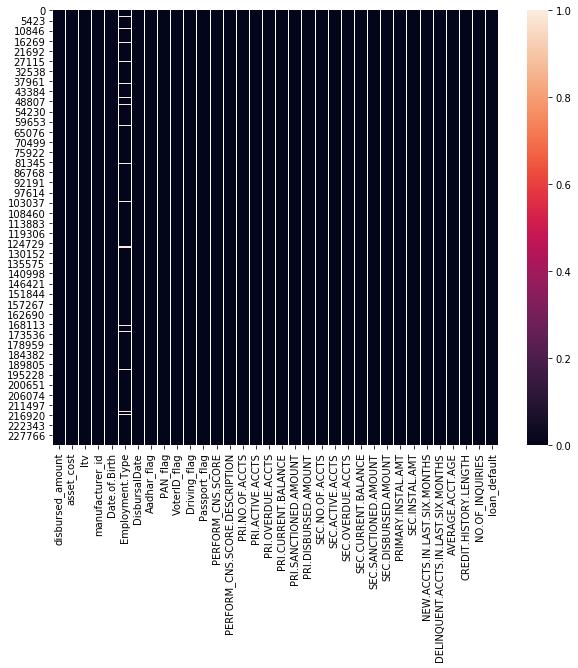

In [5]:
plt.figure(figsize=(10,8))
sns.heatmap(df.isnull())

In [6]:
def credit_risk(df):
    d1=[]
    d2=[]
    for i in df:
        p = i.split("-")
        if len(p) == 1:
            d1.append(p[0])
            d2.append('unknown')
        else:
            d1.append(p[1])
            d2.append(p[0])

    return d2

sub_risk = {'unknown':-1, 'A':13, 'B':12, 'C':11,'D':10,'E':9,'F':8,'G':7,'H':6,'I':5,'J':4,'K':3, 'L':2,'M':1}
employment_map = {'Self employed':0, 'Salaried':1,np.nan:2}

df.loc[:,'credit_risk_grade']  = credit_risk(df["PERFORM_CNS.SCORE.DESCRIPTION"])
test.loc[:,'credit_risk_grade']  = credit_risk(test["PERFORM_CNS.SCORE.DESCRIPTION"])

df.loc[:,'Credit Risk'] = df['credit_risk_grade'].apply(lambda x: sub_risk[x])
test.loc[:,'Credit Risk'] = test['credit_risk_grade'].apply(lambda x: sub_risk[x])

df.loc[:,'Employment Type'] = df['Employment.Type'].apply(lambda x: employment_map[x])
test.loc[:,'Employment Type'] = test['Employment.Type'].apply(lambda x: employment_map[x])

df=df.drop(['PERFORM_CNS.SCORE.DESCRIPTION', 'credit_risk_grade','Employment.Type'],axis=1)

test=test.drop(['PERFORM_CNS.SCORE.DESCRIPTION', 'credit_risk_grade','Employment.Type'],axis=1)

In [7]:
def age(dur):
    yr = int(dur.split('-')[2])
    if yr >=0 and yr<=19:
        return yr+2000
    else:
         return yr+1900

df['Date.of.Birth'] = df['Date.of.Birth'].apply(age)
df['DisbursalDate'] = df['DisbursalDate'].apply(age)
df['Age']=df['DisbursalDate']-df['Date.of.Birth']
df=df.drop(['DisbursalDate','Date.of.Birth'],axis=1)


test['Date.of.Birth'] = test['Date.of.Birth'].apply(age)
test['DisbursalDate'] = test['DisbursalDate'].apply(age)
test['Age']=test['DisbursalDate']-test['Date.of.Birth']
test=test.drop(['DisbursalDate','Date.of.Birth'],axis=1)

In [8]:
numerical=['disbursed_amount','asset_cost','PRI.NO.OF.ACCTS',
       'PRI.ACTIVE.ACCTS', 'PRI.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE',
       'PRI.SANCTIONED.AMOUNT', 'PRI.DISBURSED.AMOUNT', 'SEC.NO.OF.ACCTS',
       'SEC.ACTIVE.ACCTS', 'SEC.OVERDUE.ACCTS', 'SEC.CURRENT.BALANCE',
       'SEC.SANCTIONED.AMOUNT', 'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT',
       'SEC.INSTAL.AMT', 'NEW.ACCTS.IN.LAST.SIX.MONTHS',
       'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS','NO.OF_INQUIRIES','Age','NEW.ACCTS.IN.LAST.SIX.MONTHS', 
        'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS']
categorical=['manufacturer_id', 'Aadhar_flag', 'PAN_flag',
       'VoterID_flag', 'Driving_flag', 'Passport_flag', 'PERFORM_CNS.SCORE',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'AVERAGE.ACCT.AGE', 'NO.OF_INQUIRIES', 'Credit Risk','AVERAGE.ACCT.AGE','CREDIT.HISTORY.LENGTH',
       'Employment Type']

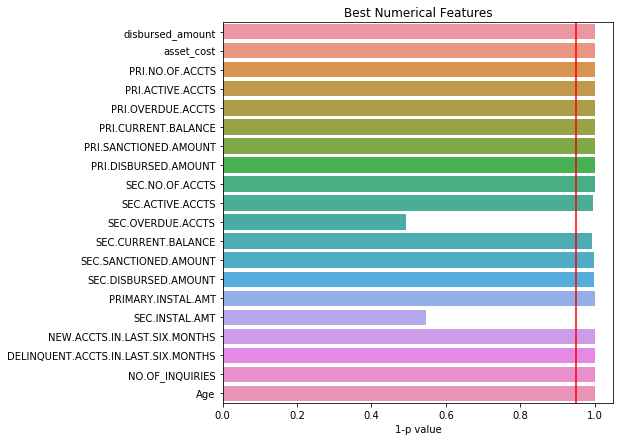

In [9]:
#T Test for numerical columns
p=[]
from scipy.stats import ttest_ind

for i in numerical:
    df1=df.groupby('loan_default').get_group(0)
    df2=df.groupby('loan_default').get_group(1)
    t,pvalue=ttest_ind(df1[i],df2[i])
    p.append(1-pvalue)
plt.figure(figsize=(7,7))
sns.barplot(x=p, y=numerical)
plt.title('Best Numerical Features')
plt.axvline(x=(1-0.05),color='r')
plt.xlabel('1-p value')
plt.show()

For visual purpose, I redid the graph to show acceptance of 'Alternative Hypothesis' for T Test. So, the ones crossing the red lines show
statistical significance. But for vehicle loans and educational loans, it is observed that Banks don't want to compromise of loosing any 
details of Secondary Account holder, since them also being the guarantor for the loan in case of a default.
But, there is a problem in this T Test, as will be observed in the next cell


In [10]:
for i in numerical:
    df1=df.groupby('loan_default').get_group(0)
    df2=df.groupby('loan_default').get_group(1)
    print(np.std(df1[i],ddof=1),np.std(df2[i],ddof=1))

13140.699007454747 12150.255527172361
19015.002867400784 18680.50260861944
5.261141650230395 5.040133626442075
2.00824201211921 1.669965727209364
0.5320262425891056 0.6034839757822149
994631.7352945375 720451.2837836256
1234346.7457193038 4525738.059420641
1240214.8264108973 4527095.229860132
0.6516570890284885 0.5273583476262503
0.3233747412831527 0.28809588122653623
0.11124913670225146 0.11046343401346292
184110.75765852304 106044.42506894954
195212.28973438882 130717.868085271
194597.53945618658 130392.7661245395
157963.98513594718 124665.51133348931
16588.052553484686 11045.628444415664
0.9729689997391793 0.885661148793889
0.3702351321845456 0.43087164170442177
0.6655358308412611 0.8351467924441973
9.837771953397374 9.658768844799795
0.9729689997391793 0.885661148793889
0.3702351321845456 0.43087164170442177


The above observations are Standard Deviations of Columns (i.e., Defaulters vs Non-defaulters). T Test for independence runs on the assumption that samples under observations should have equal Standard Deviations. Although the difference observed above seems less, it still doesn't seem acceptable. Hence, we'll go with a non-parametric test.

We'll use SelectKBest library to narrow down choices of features. This will make use of Annova test.

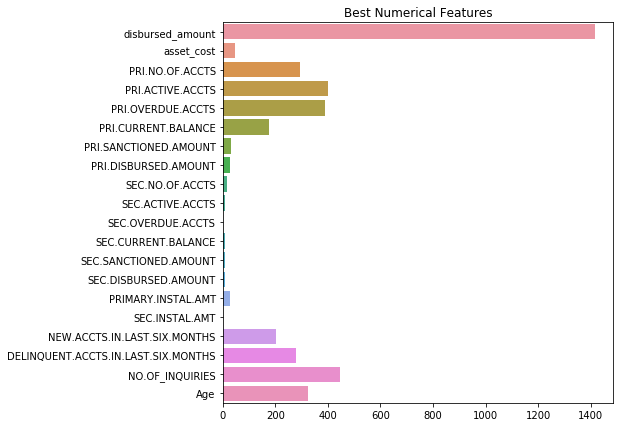

In [11]:
from sklearn.feature_selection import SelectKBest,f_classif
n = SelectKBest(score_func=f_classif, k=10)
numcols=n.fit(df[numerical],df['loan_default'])
plt.figure(figsize=(7,7))
sns.barplot(x=numcols.scores_,y=numerical)
plt.title('Best Numerical Features')
plt.show()

The graph shows that Secondary Account informations are insignificant. Again of course, banks can't afford to drop Secondary Account informations, so we'll have to combine the Primary and Secondary Account informations. 

In [12]:
df.loc[:,'No of Accounts'] = df['PRI.NO.OF.ACCTS'] + df['SEC.NO.OF.ACCTS']
df.loc[:,'PRI Inactive accounts'] = df['PRI.NO.OF.ACCTS'] - df['PRI.ACTIVE.ACCTS']
df.loc[:,'SEC Inactive accounts'] = df['SEC.NO.OF.ACCTS'] - df['SEC.ACTIVE.ACCTS']
df.loc[:,'Total Inactive accounts'] = df['PRI Inactive accounts'] + df['SEC Inactive accounts']
df.loc[:,'Total Overdue Accounts'] = df['PRI.OVERDUE.ACCTS'] + df['SEC.OVERDUE.ACCTS']
df.loc[:,'Total Current Balance'] = df['PRI.CURRENT.BALANCE'] + df['SEC.CURRENT.BALANCE']
df.loc[:,'Total Sanctioned Amount'] = df['PRI.SANCTIONED.AMOUNT'] + df['SEC.SANCTIONED.AMOUNT']
df.loc[:,'Total Disbursed Amount'] = df['PRI.DISBURSED.AMOUNT'] + df['SEC.DISBURSED.AMOUNT']
df.loc[:,'Total Installment'] = df['PRIMARY.INSTAL.AMT'] + df['SEC.INSTAL.AMT']

In [13]:
test.loc[:,'No of Accounts'] = test['PRI.NO.OF.ACCTS'] + test['SEC.NO.OF.ACCTS']
test.loc[:,'PRI Inactive accounts'] = test['PRI.NO.OF.ACCTS'] - test['PRI.ACTIVE.ACCTS']
test.loc[:,'SEC Inactive accounts'] = test['SEC.NO.OF.ACCTS'] - test['SEC.ACTIVE.ACCTS']
test.loc[:,'Total Inactive accounts'] = test['PRI Inactive accounts'] + test['SEC Inactive accounts']
test.loc[:,'Total Overdue Accounts'] = test['PRI.OVERDUE.ACCTS'] + test['SEC.OVERDUE.ACCTS']
test.loc[:,'Total Current Balance'] = test['PRI.CURRENT.BALANCE'] + test['SEC.CURRENT.BALANCE']
test.loc[:,'Total Sanctioned Amount'] = test['PRI.SANCTIONED.AMOUNT'] + test['SEC.SANCTIONED.AMOUNT']
test.loc[:,'Total Disbursed Amount'] = test['PRI.DISBURSED.AMOUNT'] + test['SEC.DISBURSED.AMOUNT']
test.loc[:,'Total Installment'] = test['PRIMARY.INSTAL.AMT'] + test['SEC.INSTAL.AMT']

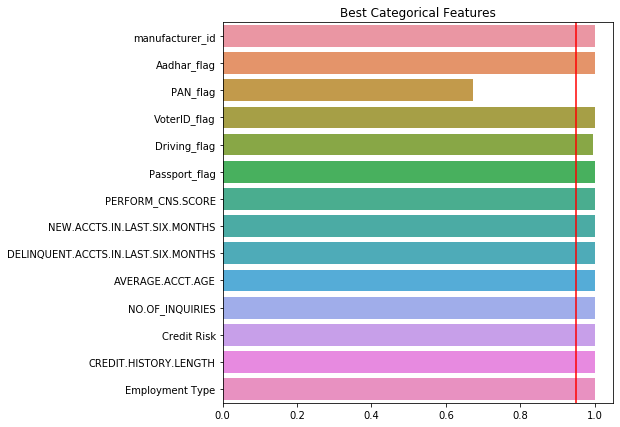

In [14]:
#Chi Square test for Categorical Columns
from scipy.stats import chi2_contingency
l=[]
for i in categorical:
    pvalue  = chi2_contingency(pd.crosstab(df['loan_default'],df[i]))[1]
    l.append(1-pvalue)
plt.figure(figsize=(7,7))
sns.barplot(x=l, y=categorical)
plt.title('Best Categorical Features')
plt.axvline(x=(1-0.05),color='r')
plt.show()

Here too, the graph shows acceptance of Alternate Hypothesis. Again, we can observe some multicollinearity between credit score and PAN Card,
since PAN Card is mandatory to obtain credit score. Hence, the Chi Square test deemed it surplus to our research. But for argument sake, we'll
keep it.

In [15]:
def duration(dur):
    yrs = int(dur.split(' ')[0].replace('yrs',''))
    mon = int(dur.split(' ')[1].replace('mon',''))
    return yrs*12+mon

In [16]:
df['AVERAGE.ACCT.AGE'] = df['AVERAGE.ACCT.AGE'].apply(duration)
df['CREDIT.HISTORY.LENGTH'] = df['CREDIT.HISTORY.LENGTH'].apply(duration)
test['AVERAGE.ACCT.AGE'] = test['AVERAGE.ACCT.AGE'].apply(duration)
test['CREDIT.HISTORY.LENGTH'] = test['CREDIT.HISTORY.LENGTH'].apply(duration)

#df.drop(['AVERAGE.ACCT.AGE','CREDIT.HISTORY.LENGTH'],axis=1,inplace=True)

In [17]:
df=df.drop(['PRI.NO.OF.ACCTS','SEC.NO.OF.ACCTS','PRI.CURRENT.BALANCE','PRI Inactive accounts','SEC Inactive accounts',
            'PRI.SANCTIONED.AMOUNT','SEC.NO.OF.ACCTS','PRI.NO.OF.ACCTS','PRI.DISBURSED.AMOUNT','PRI.ACTIVE.ACCTS', 
            'PRI.OVERDUE.ACCTS','SEC.CURRENT.BALANCE','SEC.SANCTIONED.AMOUNT', 'SEC.OVERDUE.ACCTS',
            'SEC.DISBURSED.AMOUNT','PRIMARY.INSTAL.AMT','SEC.INSTAL.AMT','disbursed_amount','SEC.ACTIVE.ACCTS'],axis=1)
test=test.drop(['PRI.NO.OF.ACCTS','SEC.NO.OF.ACCTS','PRI.CURRENT.BALANCE','PRI Inactive accounts','SEC Inactive accounts',
            'PRI.SANCTIONED.AMOUNT','SEC.NO.OF.ACCTS','PRI.NO.OF.ACCTS','PRI.DISBURSED.AMOUNT','PRI.ACTIVE.ACCTS', 
            'PRI.OVERDUE.ACCTS','SEC.CURRENT.BALANCE','SEC.SANCTIONED.AMOUNT', 'SEC.OVERDUE.ACCTS',
            'SEC.DISBURSED.AMOUNT','PRIMARY.INSTAL.AMT','SEC.INSTAL.AMT','disbursed_amount','SEC.ACTIVE.ACCTS'],axis=1)

In [18]:
nums=['asset_cost', 'ltv','PERFORM_CNS.SCORE',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES','No of Accounts', 'Total Inactive accounts',
       'Total Overdue Accounts', 'Total Current Balance', 'Total Sanctioned Amount',
       'Total Disbursed Amount', 'Total Installment','Age']

In [19]:
#test = pd.read_csv('C:/Users/Administrator/Downloads/dataset/test.csv')

In [20]:
df.columns

Index(['asset_cost', 'ltv', 'manufacturer_id', 'Aadhar_flag', 'PAN_flag',
       'VoterID_flag', 'Driving_flag', 'Passport_flag', 'PERFORM_CNS.SCORE',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES',
       'loan_default', 'Credit Risk', 'Employment Type', 'Age',
       'No of Accounts', 'Total Inactive accounts', 'Total Overdue Accounts',
       'Total Current Balance', 'Total Sanctioned Amount',
       'Total Disbursed Amount', 'Total Installment'],
      dtype='object')

In [21]:
test.columns

Index(['asset_cost', 'ltv', 'manufacturer_id', 'Aadhar_flag', 'PAN_flag',
       'VoterID_flag', 'Driving_flag', 'Passport_flag', 'PERFORM_CNS.SCORE',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES',
       'Credit Risk', 'Employment Type', 'Age', 'No of Accounts',
       'Total Inactive accounts', 'Total Overdue Accounts',
       'Total Current Balance', 'Total Sanctioned Amount',
       'Total Disbursed Amount', 'Total Installment'],
      dtype='object')

In [22]:
len(nums)

16

In [23]:
y=df.loan_default
X=df.drop("loan_default",axis=1)
from sklearn.model_selection import train_test_split,KFold,cross_val_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
lr=LogisticRegression()
lr.fit(X_train,y_train)
y_pred=lr.predict(X_test)
print('train accuracy :',lr.score(X_train,y_train))
print('test accuracy :',lr.score(X_test,y_test))
print("precision :",precision_score(y_test,y_pred),"\n")
print("recall :",recall_score(y_test,y_pred),"\n")
print("f1 score:",f1_score(y_test,y_pred),"\n")
print(classification_report(y_test,y_pred))

train accuracy : 0.7829443590042093
test accuracy : 0.7827783893519379
precision : 0.0 

recall : 0.0 

f1 score: 0.0 

              precision    recall  f1-score   support

           0       0.78      1.00      0.88     54756
           1       0.00      0.00      0.00     15191

    accuracy                           0.78     69947
   macro avg       0.39      0.50      0.44     69947
weighted avg       0.61      0.78      0.69     69947



Now this is a bad start to model building. The model isn't able to predict the 1s here. Maybe class-imbalance here. Plus, there is huge difference between macro and weighted scores. So, lets see the distribution of the target variable.

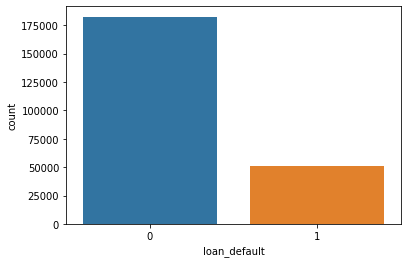

In [24]:
sns.countplot(df['loan_default'])

In [25]:
X_test.shape

(69947, 24)

In [26]:
'''n=['PERFORM_CNS.SCORE','NO.OF_INQUIRIES','No of Accounts', 'Total Inactive accounts',
       'Total Overdue Accounts', 'Total Current Balance', 'Total Sanctioned Amount',
       'Total Disbursed Amount', 'Total Installment']
data=df[n]
fig, axes = plt.subplots(nrows=3, ncols=3,figsize=(20,10))
fig.subplots_adjust(hspace=0.5)
fig.suptitle('Distributions of Credit History Features')

for ax, feature, name in zip(axes.flatten(), data.values.T, data.columns):
    sns.distplot(feature, ax=ax)
    ax.set(title=str(name))
plt.show(''')

SyntaxError: invalid syntax (<ipython-input-26-36212d4011ac>, line 12)

Maximum number of customers are applying for loan for the first time, which explains why all the above columns have so many zero values. Also, there are many notable outliers, which makes the problem more complicated.

Let's deal with outliers. Instead of using popular methods, we'll try to preserve the outlier records instead of removing them. We'll use RobustScaler to bring the observations closer to the median value (here, zero in those credit history columns).

In [27]:
from sklearn.preprocessing import  RobustScaler
rob_scaler = RobustScaler()

df[nums] = rob_scaler.fit_transform(df[nums])
test[nums]= rob_scaler.fit_transform(test[nums])

In [28]:
df.head()

,asset_cost,ltv,manufacturer_id,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,NEW.ACCTS.IN.LAST.SIX.MONTHS,...,Credit Risk,Employment Type,Age,No of Accounts,Total Inactive accounts,Total Overdue Accounts,Total Current Balance,Total Sanctioned Amount,Total Disbursed Amount,Total Installment
0,-0.930384,0.862069,45,1,0,0,0,0,0.000000,0.0,...,-1,1,0.133333,-0.333333,0.0,0.0,0.000000,0.000000,0.00000,0.000000
1,-0.400156,-0.241379,45,1,0,0,0,0,0.882006,0.0,...,5,0,0.066667,0.000000,0.0,1.0,0.739233,0.764664,0.78091,0.955833
2,-0.710877,0.867478,45,1,0,0,0,0,0.000000,0.0,...,-1,0,0.066667,-0.333333,0.0,0.0,0.000000,0.000000,0.00000,0.000000
3,-0.358405,0.789723,45,1,0,0,0,0,0.449853,0.0,...,2,0,-0.466667,0.666667,3.0,0.0,0.000000,0.000000,0.00000,0.014882
4,-0.789484,0.783638,45,1,0,0,0,0,0.000000,0.0,...,-1,0,0.600000,-0.333333,0.0,0.0,0.000000,0.000000,0.00000,0.000000


In [29]:
df['Missing Features'] = (df == 0).astype(int).sum(axis=1)

Now, for the zero observations, we'll make a new feature that counts the features having zero. This will act as yardstick between people who have a credit history and those who dont. Of course, people with no credit history will likely have more than 9 features as zero, unlikely in case of customers with credit history.

In [30]:
df['Missing Features'] = (df == 0).astype(int).sum(axis=1)
test['Missing Features'] = (test == 0).astype(int).sum(axis=1)

Now let's try on our base model. We'll use XGBoost to reduce bias and variance errors, and do some hyperparameter tuning.

In [31]:
y=df.loan_default
X=df.drop("loan_default",axis=1)
from sklearn.model_selection import train_test_split,KFold,cross_val_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [32]:
X_test.shape

(69947, 25)

Train/Test split results:
LogisticRegression accuracy is 0.783
LogisticRegression log_loss is 0.492
LogisticRegression auc is 0.675


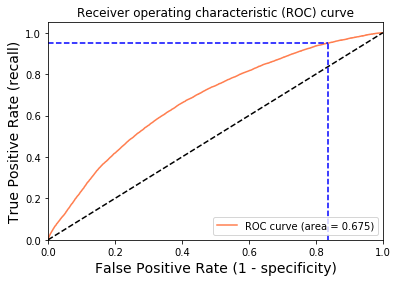

Using a threshold of 0.117 guarantees a sensitivity of 0.950 and a specificity of 0.163, i.e. a false positive rate of 83.66%.


In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss

logreg = LogisticRegression()
logreg.fit(X_train,y_train)
logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]
[fpr, tpr, thr] = roc_curve(y_test, y_pred_proba)
print('Train/Test split results:')
print(logreg.__class__.__name__+" accuracy is %2.3f" % accuracy_score(y_test, y_pred))
print(logreg.__class__.__name__+" log_loss is %2.3f" % log_loss(y_test, y_pred_proba))
print(logreg.__class__.__name__+" auc is %2.3f" % auc(fpr, tpr))

idx = np.min(np.where(tpr > 0.95)) # index of the first threshold for which the sensibility > 0.95

plt.figure()
plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0,fpr[idx]], [tpr[idx],tpr[idx]], 'k--', color='blue')
plt.plot([fpr[idx],fpr[idx]], [0,tpr[idx]], 'k--', color='blue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
plt.ylabel('True Positive Rate (recall)', fontsize=14)
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

print("Using a threshold of %.3f " % thr[idx] + "guarantees a sensitivity of %.3f " % tpr[idx] +  
      "and a specificity of %.3f" % (1-fpr[idx]) + 
      ", i.e. a false positive rate of %.2f%%." % (np.array(fpr[idx])*100))

In [34]:
from sklearn.ensemble import RandomForestClassifier
rcf = RandomForestClassifier()
rcf.fit(X_train,y_train)
y_pred=rcf.predict(X_test)
print("accuracy train:",rcf.score(X_train,y_train),"\n")
print("accuracy test:",rcf.score(X_test,y_test),"\n")
print("precision :",precision_score(y_test,y_pred),"\n")
print("Recall :",recall_score(y_test,y_pred),"\n")
print("f1 score:",f1_score(y_test,y_pred),"\n")
print("Confusion Matrix \n",confusion_matrix(y_test,y_pred))

accuracy train: 1.0 

accuracy test: 0.9265157905271134 

precision : 0.9664037122969837 

Recall : 0.6854716608518202 

f1 score: 0.8020488330894248 

Confusion Matrix 
 [[54394   362]
 [ 4778 10413]]


In [35]:
logreg.fit(X_train,y_train)
y_pred=logreg.predict(X_test)
print("accuracy train:",logreg.score(X_train,y_train),"\n")
print("accuracy test:",logreg.score(X_test,y_test),"\n")
print("precision :",precision_score(y_test,y_pred),"\n")
print("Recall :",recall_score(y_test,y_pred),"\n")
print("f1 score:",f1_score(y_test,y_pred),"\n")
print("Confusion Matrix \n",confusion_matrix(y_test,y_pred))

accuracy train: 0.7835509506332449 

accuracy test: 0.7837362574520709 

precision : 0.5528052805280528 

Recall : 0.022052531103943125 

f1 score: 0.04241311641450909 

Confusion Matrix 
 [[54485   271]
 [14856   335]]


In [36]:
from sklearn.model_selection import GridSearchCV

In [37]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=3)
gsearch1.fit(X_train,y_train)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([ 39.80410981,  38.1475753 ,  37.29598673,  63.05757872,
          66.52392681,  67.55200354, 101.92833177,  80.9726584 ,
          77.80413985, 116.66623068, 111.15338588,  85.55437382]),
  'std_fit_time': array([ 0.18178566,  0.83335326,  0.78376307,  0.33409909,  1.12361849,
          0.80408995,  5.22233884,  1.72813339,  1.24801015,  0.35060131,
          0.74962271, 16.95122227]),
  'mean_score_time': array([0.47739434, 0.51070849, 0.56934174, 0.77222451, 0.61098401,
         0.53835893, 0.61431583, 0.67361554, 0.57267324, 0.82486161,
         0.71392576, 0.57933092]),
  'std_score_time': array([0.01700765, 0.07998338, 0.09680333, 0.24805399, 0.06499744,
         0.05630841, 0.02378116, 0.0984226 , 0.06253358, 0.03721951,
         0.0108667 , 0.06393408]),
  'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, False, False]

In [38]:
param_test2b = {
 'max_depth':range(7,10,2)
}
gsearch2b = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=4,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2b, scoring='roc_auc',n_jobs=4,iid=False, cv=3)
gsearch2b.fit(X_train,y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, gamma=0, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=4, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=140, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=1, seed=27, subsample=0.8,
                                     tree_method=

In [39]:
gsearch2b.cv_results_, gsearch2b.best_params_, gsearch2b.best_score_

({'mean_fit_time': array([88.0822564 , 79.92992139]),
  'std_fit_time': array([ 0.35712933, 24.8196374 ]),
  'mean_score_time': array([0.79854449, 0.64096721]),
  'std_score_time': array([0.12970463, 0.09716328]),
  'param_max_depth': masked_array(data=[7, 9],
               mask=[False, False],
         fill_value='?',
              dtype=object),
  'params': [{'max_depth': 7}, {'max_depth': 9}],
  'split0_test_score': array([0.99790289, 0.99903401]),
  'split1_test_score': array([0.99762497, 0.9987827 ]),
  'split2_test_score': array([0.99762279, 0.99886105]),
  'mean_test_score': array([0.99771688, 0.99889259]),
  'std_test_score': array([0.00013153, 0.00010499]),
  'rank_test_score': array([2, 1])},
 {'max_depth': 9},
 0.998892587995571)

In [40]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=9,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(X_train,y_train)
gsearch3.best_params_, gsearch3.best_score_

({'gamma': 0.2}, 0.9991531429460663)

In [41]:
xgb4 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=5000,
 max_depth=9,
 min_child_weight=1,
 gamma=0.4,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=0.005,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

In [42]:
xgb4.fit(X_train,y_train)
y_pred=xgb4.predict(X_test)
print("accuracy train:",xgb4.score(X_train,y_train),"\n")
print("accuracy test:",xgb4.score(X_test,y_test),"\n")
print("precision :",precision_score(y_test,y_pred),"\n")
print("Recall :",recall_score(y_test,y_pred),"\n")
print("f1 score:",f1_score(y_test,y_pred),"\n")
print("Confusion Matrix \n",confusion_matrix(y_test,y_pred))

accuracy train: 0.9999448553064513 

accuracy test: 0.998413084192317 

precision : 0.9986112948022748 

Recall : 0.9940754394049108 

f1 score: 0.9963382047306436 

Confusion Matrix 
 [[54735    21]
 [   90 15101]]


Voila! we smashed the record set on all these scores.

In [43]:
import sklearn.metrics as metrics

In [44]:
probs = xgb4.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)

In [45]:
print(fpr, tpr)

[0.         0.         0.         ... 0.9982285  0.99826503 1.        ] [0.00000000e+00 6.58284511e-05 5.26627608e-04 ... 1.00000000e+00
 1.00000000e+00 1.00000000e+00]


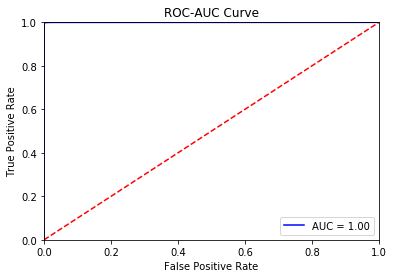

In [46]:
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC-AUC Curve')
plt.show()

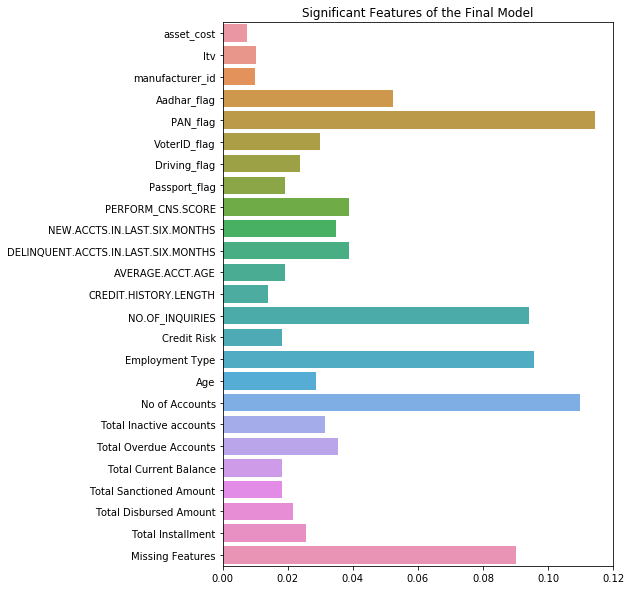

In [47]:
plt.figure(figsize=(7,10))
sns.barplot(x=xgb4.feature_importances_,y=X.columns)
plt.title('Significant Features of the Final Model')
plt.show()

In [ ]:
 y_pred = xgb4.predict_proba(X_test)
pd.DataFrame(y_pred)

In [ ]:
test